In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(1)

In [5]:
import os
import sys
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:

/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [7]:
import glob
import pickle

In [8]:
glob.glob('../data/simulated/*')

['../data/simulated/hawkes_synth_data_1d.pkl',
 '../data/simulated/hawkes_synth_data_2d.pkl',
 '../data/simulated/README.md']

In [9]:
from load_synth_data import process_loaded_sequences, one_hot_embedding

## 1D process

In [10]:
# Load data simulated using tick
with open("../data/simulated/hawkes_synth_data_1d.pkl", "rb") as f:
    loaded_hawkes_data = pickle.load(f)

In [11]:
loaded_hawkes_data.keys()

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])

In [12]:
mu = loaded_hawkes_data['mu']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print(mu)
print(decay)
print(tmax)

1.0
5.0
60.0


In [13]:
times_tensor, types_tensor, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data)

## 2D process

In [10]:
# Load data simulated using tick
with open("../data/simulated/hawkes_synth_data_2d.pkl", "rb") as f:
    loaded_hawkes_2d_data = pickle.load(f)

In [11]:
loaded_hawkes_2d_data.keys()

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])

In [12]:
print(loaded_hawkes_2d_data['mu'])
print(loaded_hawkes_2d_data['alpha'])
print(loaded_hawkes_2d_data['decay'])
tmax = loaded_hawkes_2d_data['tmax']
print(f"tmax: {tmax}")

[0.7 1. ]
[[0.1  0.15]
 [0.01 0.01]]
0.01
tmax: 60.0


In [13]:
times_tensor, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_2d_data)

onehot_types = one_hot_embedding(seq_types, 3)

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= \sigma(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [48]:
from models.decayrnn import HawkesDecayRNN
from train_functions import train_decayrnn

hidden_size = 24
model = HawkesDecayRNN(2, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.015)

In [49]:
# define training data
train_size = 1000
print("Train size %d" % train_size)

train_times_tensor = times_tensor[:, :train_size]
train_onehot_types = onehot_types[:, :train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_onehot_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 1000
Train event times shape torch.Size([167, 1000])
Train event types shape torch.Size([167, 1000, 3])
Train seq lengths shape torch.Size([1000])


In [47]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 50

loss_hist = train_decayrnn(model, optimizer, train_times_tensor,
                           train_onehot_types, train_seq_lengths, tmax,
                           BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 32
Number of epochs 60


In [87]:
from train_functions import plot_loss

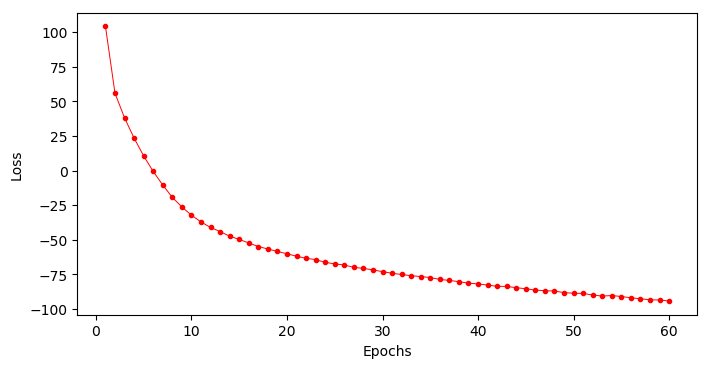

In [88]:
plot_loss(EPOCHS, loss_hist)

## Save to file

In [86]:
import datetime

ts = '{:%Y%m%d-%H%M%S}'.format(datetime.datetime.now())

flname = '{:}-{:}.pth'.format(model.__class__.__name__, ts)
print(flname)
fpath = '../saved_models/{:}'.format(flname)
print(fpath)

torch.save(model.state_dict(), fpath)

HawkesDecayRNN-20181126-104513.pth
../saved_models/HawkesDecayRNN-20181126-104513.pth


## Sequence generation

In [51]:
from models.decayrnn import generate_sequence

In [52]:
inp_size = model.input_size
inp_size

3

In [53]:
# Build a statistic for the no. of events
gen_seq_lengths = []
gen_seq_types_lengths = []
n_gen_seq = 500 # number of generated sequences
for i in range(n_gen_seq):
    (gen_event_times, gen_event_types,
     gen_event_intens, gen_event_decay) = generate_sequence(model, tmax)
    gen_seq_lengths.append(len(gen_event_times) - 1)
    gen_seq_types_lengths.append([
        (gen_event_types == i).sum() for i in range(inp_size)
    ])
gen_seq_lengths = np.array(gen_seq_lengths)
gen_seq_types_lengths = np.array(gen_seq_types_lengths)

print("Mean generated sequence length: {}".format(gen_seq_lengths.mean()))
print("Generated sequence length std. dev: {}".format(gen_seq_lengths.std()))
MODEL_NAME = "Decay-RNN"

Mean generated sequence length: 44.746
Generated sequence length std. dev: 6.530044716539084


In [54]:
gen_seq_types_lengths

array([[13, 11, 19],
       [12, 19, 18],
       [13, 12, 21],
       ...,
       [11, 22, 19],
       [14, 17, 17],
       [12, 14, 12]])

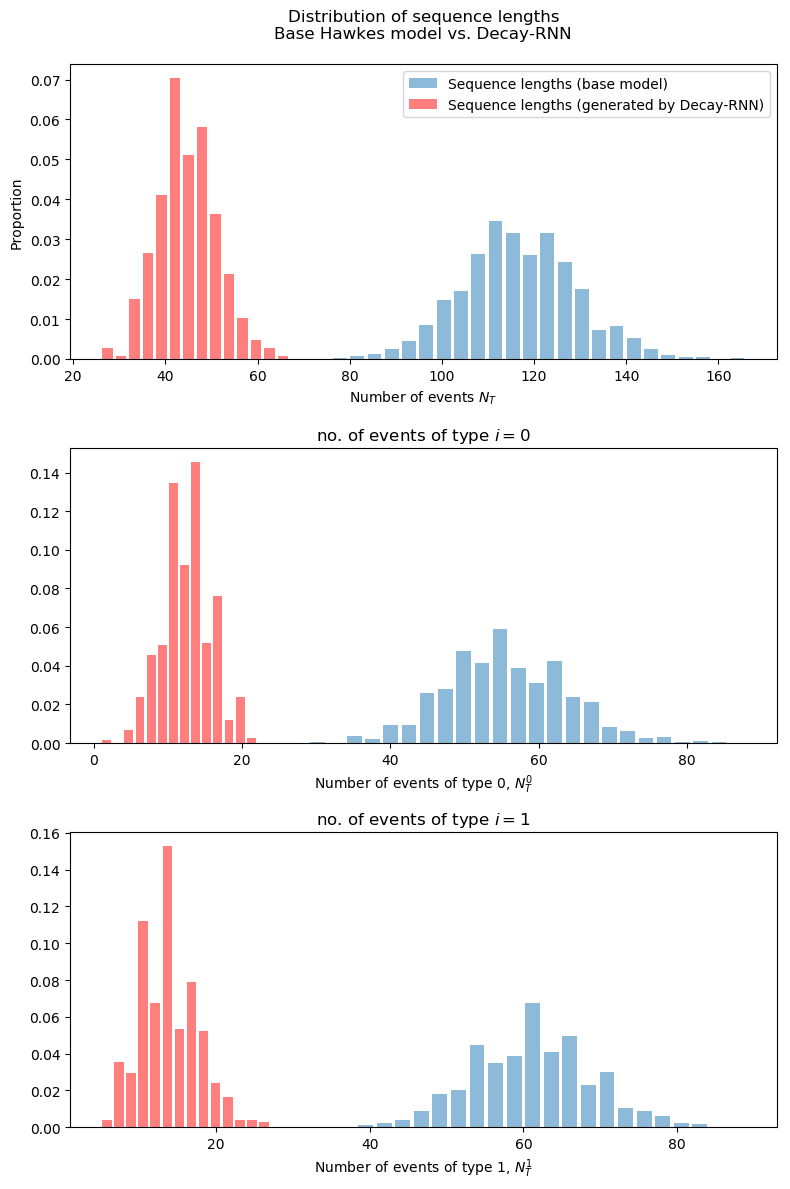

In [55]:
fig, axes = plt.subplots(inp_size, 1, figsize=(8,12), dpi=100)
ax0 = axes[0]
axt = axes[1:]
_ = ax0.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, density=True)
_ = ax0.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (generated by {:})".format(MODEL_NAME),
            rwidth=0.8, alpha=0.5, color='red', density=True)
ax0.legend()
ax0.set_ylabel('Proportion')
ax0.set_xlabel('Number of events $N_T$')
ax0.set_title("""Distribution of sequence lengths
Base Hawkes model vs. {:}
""".format(MODEL_NAME))
for i, ax in enumerate(axt):
    # get the sequence lengths for the event types
    typ_seq_lengths = (seq_types == i).sum(dim=0)
    gen_typ_seq_lengths = gen_seq_types_lengths[:, i]
    ax.hist(typ_seq_lengths, bins=2*int(typ_seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, density=True)
    ax.hist(gen_typ_seq_lengths,
            bins=2*int(gen_typ_seq_lengths.shape[0]**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, color='red', density=True)
    ax.set_xlabel("Number of events of type {}, $N_T^{}$".format(i, i))
    ax.set_title('no. of events of type $i={}$'.format(i))
fig.tight_layout()

In [56]:
RESULT_BASEDIR = "../results"
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "seq_length_distrib"
fig.savefig("{:}/{:}_{:}.pdf".format(RESULT_BASEDIR, model_perf_indicator, MODEL_NAME))

The number of events does not fit.

In [57]:
def plot_events_and_intensity(event_times: torch.Tensor, seq_types: torch.Tensor,
                              hidden_states: torch.Tensor, event_decay: torch.Tensor):
    sequence_length = event_times.shape[0]
    print("no. of events: {}".format(sequence_length))
    evt_times = event_times.numpy()
    evt_types = seq_types.numpy()
    inp_size = model.input_size
    fig, ax = plt.subplots(1, 1, sharex=True, dpi=110,
                                   figsize=(10,1))
    ax.set_ylim((-0.6, 1.6))
    ts_y = np.random.rand(sequence_length)
    inpt_size = model.input_size
    for k in range(inpt_size):
        mask = evt_types == k
        ax.scatter(evt_times[mask], ts_y[mask], s=9,
                   label="{}".format(k), alpha=0.7)
        ax.vlines(evt_times[mask], -0.6, 1.6, linewidth=0.3, linestyles='--', alpha=0.5)
    ax.legend()

no. of events: 38


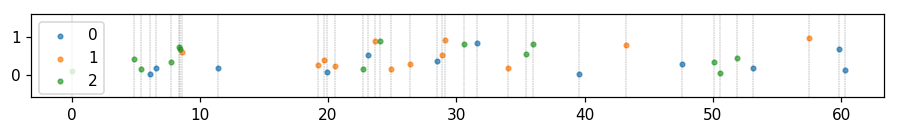

In [58]:
gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay = generate_sequence(model, tmax)
plot_events_and_intensity(gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay)

In [62]:
from models.decayrnn import read_predict
import torch.nn.functional as F

In [64]:
num_errors = 0

for index in range(500):
    oh_real, oh_pred, type_distrib = read_predict(
        model, times_tensor[:,index],
        onehot_types[:,index], seq_lengths[index])
    num_errors += int(not(oh_real.equal(oh_pred)))

Running next event type prediction for seq. #0
Running next event type prediction for seq. #1
Running next event type prediction for seq. #2
Running next event type prediction for seq. #3
Running next event type prediction for seq. #4
Running next event type prediction for seq. #5
Running next event type prediction for seq. #6
Running next event type prediction for seq. #7
Running next event type prediction for seq. #8
Running next event type prediction for seq. #9
Running next event type prediction for seq. #10
Running next event type prediction for seq. #11
Running next event type prediction for seq. #12
Running next event type prediction for seq. #13
Running next event type prediction for seq. #14
Running next event type prediction for seq. #15
Running next event type prediction for seq. #16
Running next event type prediction for seq. #17
Running next event type prediction for seq. #18
Running next event type prediction for seq. #19
Running next event type prediction for seq. #20
Ru

Running next event type prediction for seq. #174
Running next event type prediction for seq. #175
Running next event type prediction for seq. #176
Running next event type prediction for seq. #177
Running next event type prediction for seq. #178
Running next event type prediction for seq. #179
Running next event type prediction for seq. #180
Running next event type prediction for seq. #181
Running next event type prediction for seq. #182
Running next event type prediction for seq. #183
Running next event type prediction for seq. #184
Running next event type prediction for seq. #185
Running next event type prediction for seq. #186
Running next event type prediction for seq. #187
Running next event type prediction for seq. #188
Running next event type prediction for seq. #189
Running next event type prediction for seq. #190
Running next event type prediction for seq. #191
Running next event type prediction for seq. #192
Running next event type prediction for seq. #193
Running next event t

Running next event type prediction for seq. #344
Running next event type prediction for seq. #345
Running next event type prediction for seq. #346
Running next event type prediction for seq. #347
Running next event type prediction for seq. #348
Running next event type prediction for seq. #349
Running next event type prediction for seq. #350
Running next event type prediction for seq. #351
Running next event type prediction for seq. #352
Running next event type prediction for seq. #353
Running next event type prediction for seq. #354
Running next event type prediction for seq. #355
Running next event type prediction for seq. #356
Running next event type prediction for seq. #357
Running next event type prediction for seq. #358
Running next event type prediction for seq. #359
Running next event type prediction for seq. #360
Running next event type prediction for seq. #361
Running next event type prediction for seq. #362
Running next event type prediction for seq. #363
Running next event t

In [67]:
num_errors

346